# Stima dei livelli di obesità in base alle abitudini alimentari e alle condizioni fisiche
Progetto di Programmazione di Applicazioni Data Intensive - 2022/2023

**Realizzato da:** Fabio Veroli fabio.veroli@studio.unibo.it

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## Caricamento dei dati
L'obbiettivo del problema che andremo a studiare è stimare il livello di obesità di una persona in base alle sue abitudini alimentari e alle sue condizioni fisiche. 

Il dataset utilizzato, consultabile presso [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition), riguarda i dati di circa 2000 individui provenienti da Messico, Peru e Colombia; il 23% dei dati è stato ottenuto da un sondaggio online, mentre il restante 77% è stato generato sinteticamente utilizzando lo strumento Weka e il filtro SMOTE. 

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/Fab-Ver/DataIntensive-Project/main/data/ObesityDataSet.csv",delimiter=',')
df.head(5)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


### Significato delle colonne
Le feature presenti nel dataset sono: 
- `Gender`: genere dell'individuo. Possibili valori: Female o Male
- `Age`: età dell'individuo (valore numerico)
- `Height`: altezza dell'individuo in metri (valore numerico)
- `Weight`: peso dell'individuo in kilogrammi (valore numerico)
- `family_history_with_overweight`: indica se nella famiglia dell'individuo sono presenti altri familiari che soffrono di obesità. Possibili valori: yes o no
- `FAVC`: indica se l'individuo consuma frequentemente cibi ad alto contenuto calorico. Possibili valori: yes o no
- `FCVC`: indica quanto spesso l'individuo mangia verdure durante i pasti. Possibili valori: Never (1), Sometimes (2), Always (3)
- `NCP`: numero di pasti principali consumati dall'individuo in un giorno (valore numerico)
- `CAEC`: indica quanto spesso l'individuo consuma cibi tra due pasti. Possibili valori: No, Sometimes, Frequently, Always
- `SMOKE`: indica se l'individuo fuma. Possibili valori: yes o no
- `CH20`: indica il consumo giornaliero di acqua. Possibili valori: less than a liter (1), between 1 and 2L (2), more than 2L (3)
- `SCC`: indica se l'individuo monitora le calorie che assume giornalemente. Possibili valori: yes o no
- `FAF`: indica il numero di giorni in una settimana in cui l'individuo effettua attività fisica. Possibili valori: never (0), 1-2 days (1), 2-4 days (2), 4-5 days (3)
- `TUE`: indica il numero di ore giornaliere passate utilizzando dispositivi tecnologici come cellulare, videogiochi, televisione, computer. Possibili valori: 0-2 hours (0), 3-5 hours (1), more than 5 hours (2)
- `CALC`: indica quanto spesso l'individuo consuma alcol. Possibili valori: No, Sometimes, Frequently, Always
- `MTRANS`: tipo di mezzo di trasporto utilizzato dall'individuo. Possibili valori: 'Public_Transportation', 'Walking', 'Automobile', 'Motorbike', 'Bike'

La variabile che tenteremo di predirre è: 
- `NObeyesdad`: classificazione dei livelli di obesità basata sull'indice di massa corporea (BMI) secondo la WHO e la normativa messicana.

Modificihiamo i nomi delle colonne per renderli più esplicativi al fine dello studio del problema. 

In [3]:
col_names = {
    "Gender" : "gender",
    "Age" : "age",
    "Height" : "height",
    "Weight" : "weight",
    "family_history_with_overweight" : "overweight_in_family",
    "FAVC" : "high_caloric_food_frequently",
    "FCVC" : "freq_vegetables_cons",
    "NCP" : "num_meals",
    "CAEC" : "freq_cons_food_between_meals",
    "SMOKE" : "smoke",
    "CH2O" : "water_cons",
    "SCC" : "cal_cons_monitoring",
    "FAF" : "freq_physical_activity",
    "TUE" : "time_using_technology",
    "CALC" : "freq_alcohol_cons",
    "MTRANS" : "transportation",
    "NObeyesdad": "BMI_classification",
}
df.rename(columns=col_names,inplace=True)

In [4]:
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gender                        2111 non-null   object 
 1   age                           2111 non-null   float64
 2   height                        2111 non-null   float64
 3   weight                        2111 non-null   float64
 4   overweight_in_family          2111 non-null   object 
 5   high_caloric_food_frequently  2111 non-null   object 
 6   freq_vegetables_cons          2111 non-null   float64
 7   num_meals                     2111 non-null   float64
 8   freq_cons_food_between_meals  2111 non-null   object 
 9   smoke                         2111 non-null   object 
 10  water_cons                    2111 non-null   float64
 11  cal_cons_monitoring           2111 non-null   object 
 12  freq_physical_activity        2111 non-null   float64
 13  tim

Dall'analisi dell'utilizzo della memoria emerge che il dataframe occupa molto spazio in memoria a causa di alcuni attributi rappresentati come oggetti. Passiamo quindi a classificare gli attributi in categorici, booleani e numerici, in modo da rappresentare gli attributi con tipi di dati più efficienti. 

In [4]:
cat_vars = ["gender", "freq_vegetables_cons", "freq_cons_food_between_meals", 
           "water_cons", "freq_alcohol_cons", "freq_physical_activity", "time_using_technology",
           "transportation", "BMI_classification"]
bool_vars = ["overweight_in_family", "high_caloric_food_frequently", "smoke", "cal_cons_monitoring"]
int_vars = ["age", "num_meals"]
float_vars = ["height", "weight"]

Convertiamo tutte gli attributi con valori possibili `yes` o `no` in attributi booleani.

In [5]:
mapping = {"yes" : True, "no" : False}
for col_name in bool_vars: 
    df[col_name] = df[col_name].map(mapping)

Per le variabili `age` e `num_meals` tronchiamo i valori decimali in modo da ottenere un valore intero.

In [8]:
for col_name in int_vars:
    df[col_name] = df[col_name].astype(int)

Alcuni attributi catagorici sono rappresentati in formato numerico, mentre altre in formato di stringa. Rappresentiamo tutti gli attributi che rappresentano una quantità misurabile utilizzando dei numeri crescenti. Per alcuni attributi già in formato numerico è necessario effettuare una conversione in quanto i dati importati risultano incorretti.  

In [6]:
mapping_cat_to_num = {"no" : 0, "Sometimes" : 1, "Frequently" : 2, "Always" : 3}
df["freq_cons_food_between_meals"] = df["freq_cons_food_between_meals"].map(mapping_cat_to_num)
df["freq_alcohol_cons"] = df["freq_alcohol_cons"].map(mapping_cat_to_num)

#for col_name in ["freq_vegetables_cons","water_cons", "freq_physical_activity", "time_using_technology"]:
#    df[col_name] = df[col_name].astype(int)

for col_name in cat_vars:
    df[col_name] = df[col_name].astype('category')

Come si può notare dal seguente comando l'occupazione di memoria del dataset è stata drasticamente ridotta, classififcando in modo adeguato tutti i dati.

In [8]:
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   gender                        2111 non-null   category
 1   age                           2111 non-null   float64 
 2   height                        2111 non-null   float64 
 3   weight                        2111 non-null   float64 
 4   overweight_in_family          2111 non-null   bool    
 5   high_caloric_food_frequently  2111 non-null   bool    
 6   freq_vegetables_cons          2111 non-null   category
 7   num_meals                     2111 non-null   float64 
 8   freq_cons_food_between_meals  2111 non-null   category
 9   smoke                         2111 non-null   bool    
 10  water_cons                    2111 non-null   category
 11  cal_cons_monitoring           2111 non-null   bool    
 12  freq_physical_activity        2111 non-null   ca

In [9]:
df.head()

,gender,age,height,weight,overweight_in_family,high_caloric_food_frequently,freq_vegetables_cons,num_meals,freq_cons_food_between_meals,smoke,water_cons,cal_cons_monitoring,freq_physical_activity,time_using_technology,freq_alcohol_cons,transportation,BMI_classification
0,Female,21.0,1.62,64.0,True,False,2.0,3.0,1,False,2.0,False,0.0,1.0,0,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,True,False,3.0,3.0,1,True,3.0,True,3.0,0.0,1,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,True,False,2.0,3.0,1,False,2.0,False,2.0,1.0,2,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,False,False,3.0,3.0,1,False,2.0,False,2.0,0.0,2,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,False,False,2.0,1.0,1,False,2.0,False,0.0,0.0,1,Public_Transportation,Overweight_Level_II


## Analisi Esplorativa

Eseguiamo un'analisi di base dei dati, in particolare visualizziamo il numero e la distribuzione delle classi. 

In [10]:
len(df["BMI_classification"].unique())

7

In totale abbiamo 7 classi che individuano il livello di obesità di una persona, visualizziamo il numero di elementi per ogni classe e la loro distribuzione all'interno del dataset. 

In [11]:
df["BMI_classification"].value_counts()

Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        297
Overweight_Level_I     290
Overweight_Level_II    290
Normal_Weight          287
Insufficient_Weight    272
Name: BMI_classification, dtype: int64

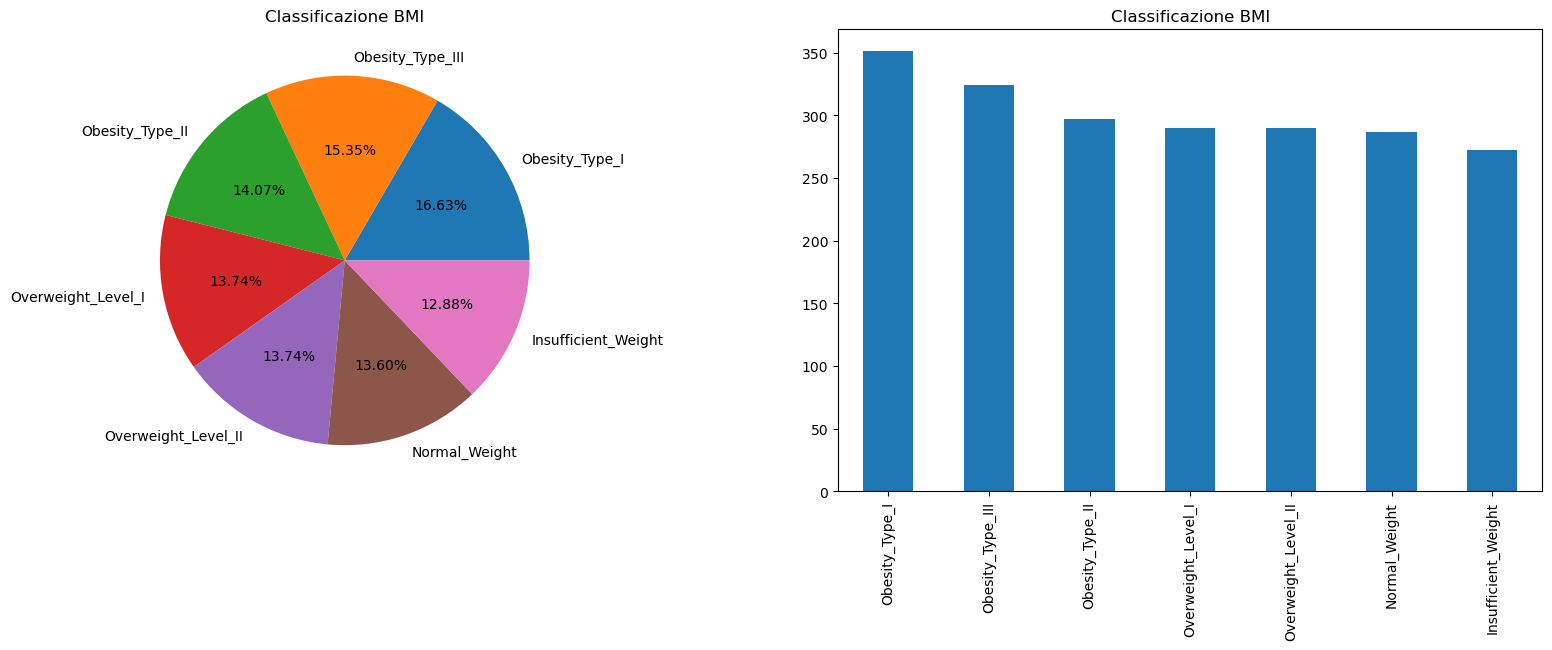

In [12]:
plt.figure(figsize=(20, 6))
df["BMI_classification"].value_counts().plot.pie(autopct="%.2f%%",ylabel="",title="Classificazione BMI",ax=plt.subplot(1, 2, 1));
df["BMI_classification"].value_counts().plot.bar(title="Classificazione BMI",ax=plt.subplot(1, 2, 2));

Come si può notare dai grafici le classi sono pressochè bilanciate. Ci aspettavamo questo risultato in quanto, come da indicazioni del dataset, il 77% dei dati sono stati generati sintenticamente proprio allo scopo di bilanciare le classi per una migliore prestazioni del dataset, che nella sua forma originale costituita dai soli dati raccolti tramite sondaggi presentava uno sbilanciamento con predominazione della classe `Normal`.

Possiamo poi ottenere e visualizzare in un grafico alcune statisiche su età, peso, altezza e numero di pasti cosumati da parte di un individuo. 

In [13]:
df.describe()

,age,height,weight,num_meals
count,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.685628
std,6.345968,0.093305,26.191172,0.778039
min,14.000000,1.450000,39.000000,1.000000
25%,19.947192,1.630000,65.473343,2.658738
50%,22.777890,1.700499,83.000000,3.000000
75%,26.000000,1.768464,107.430682,3.000000
max,61.000000,1.980000,173.000000,4.000000


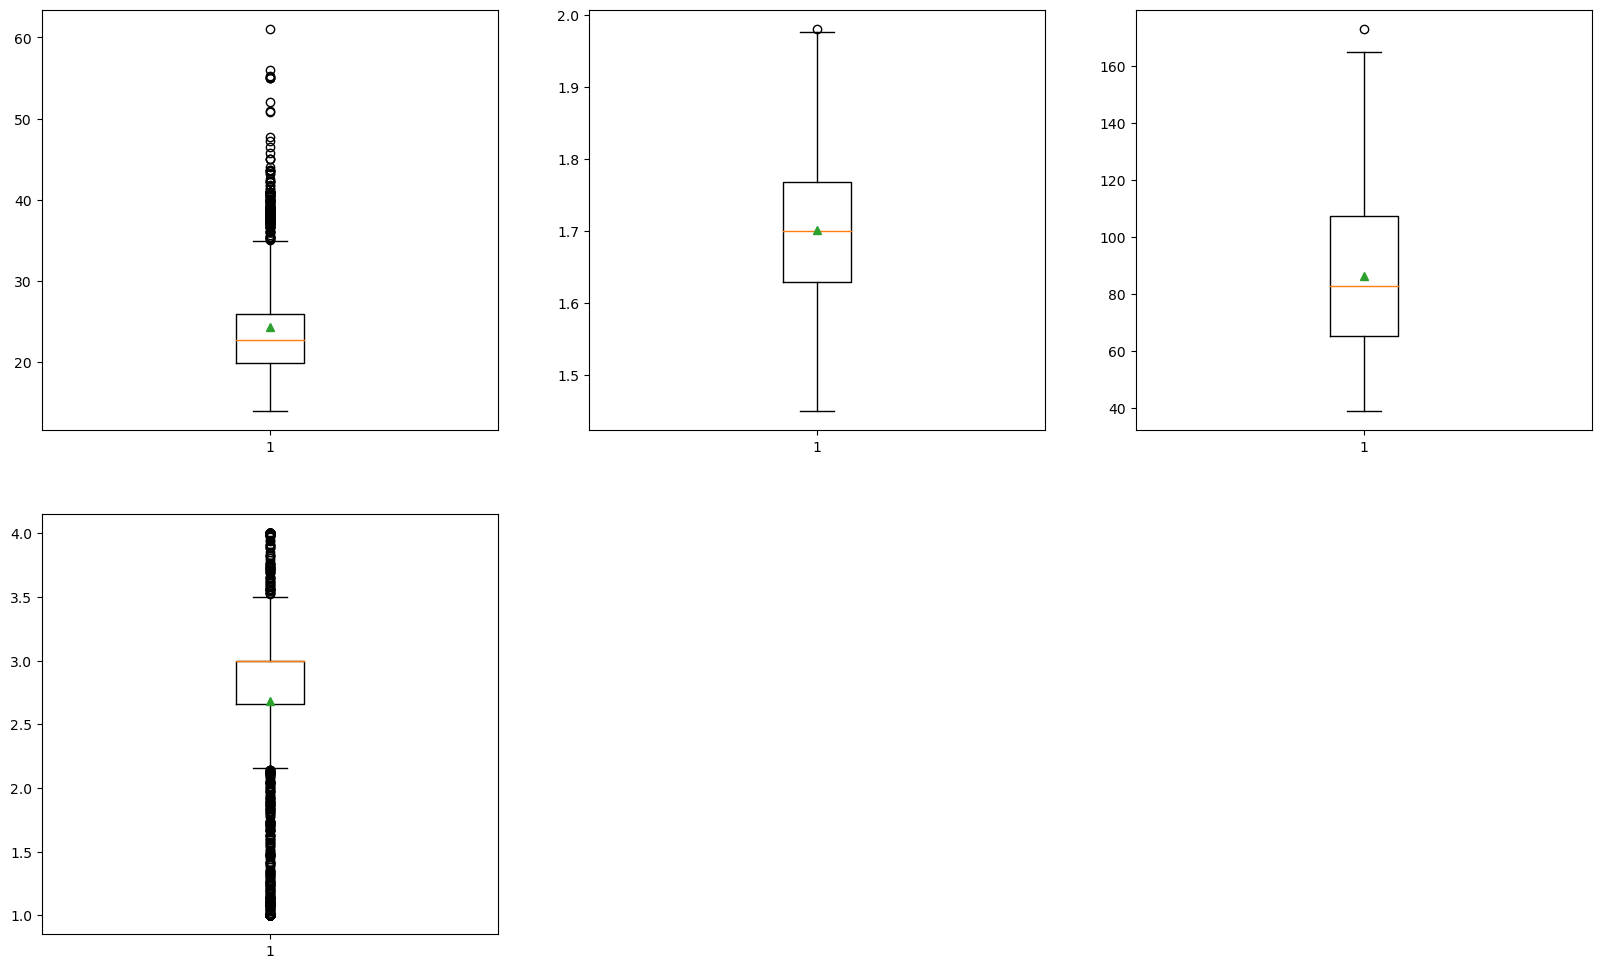

In [14]:
plt.figure(figsize=(20, 12))
for i, col in enumerate(["age","height", "weight", "num_meals"],start=1):
    plt.subplot(2,3,i).boxplot(df[col],showmeans=True);

Dai grafici si nota che la serie `age` ha molti dati molto distanti dalla mediana (outlier).

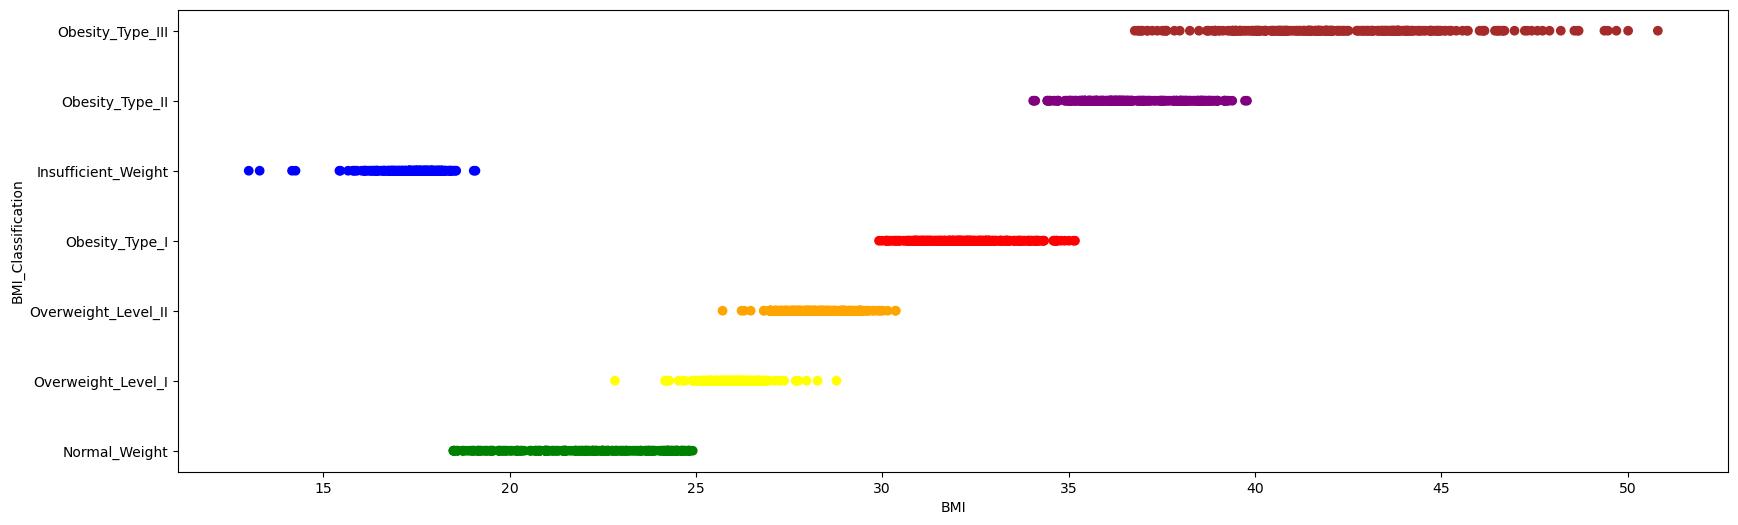

In [15]:
class_colors = df["BMI_classification"].map({
    'Normal_Weight': 'Green',
    'Overweight_Level_I': 'Yellow',
    'Overweight_Level_II': 'Orange',
    'Obesity_Type_I': 'Red',
    'Insufficient_Weight': 'Blue',
    'Obesity_Type_II': 'Purple',
    'Obesity_Type_III': 'Brown'
})
plt.figure(figsize=(20, 6))
plt.scatter(df["weight"]/(df["height"]**2),df["BMI_classification"],c=class_colors);
plt.xlabel("BMI");
plt.ylabel("BMI_Classification");

Dal grafico si può notare la correlazione lineare tra la `BMI_classification` e $\frac{\text{Weight}}{\text{Height}\times \text{Height}}$, quest'ultima misura rappresenta infatti il BMI di un individuo, che è usato per classificare il livello di obesità. Solo i dati appartenenti alla classe `Insufficient_Weight` sembrano non seguire la stessa tendenza degli altri.

## Preparazione dei dati

Prepariamo i dati per l'addestramento dei modelli. Separiamo la variabile target `BMI_classification` dalle restanti variabili. 

In [7]:
X = df.drop(columns=["BMI_classification"])
y = df["BMI_classification"]

In [17]:
X.head()

,gender,age,height,weight,overweight_in_family,high_caloric_food_frequently,freq_vegetables_cons,num_meals,freq_cons_food_between_meals,smoke,water_cons,cal_cons_monitoring,freq_physical_activity,time_using_technology,freq_alcohol_cons,transportation
0,Female,21.0,1.62,64.0,True,False,2.0,3.0,1,False,2.0,False,0.0,1.0,0,Public_Transportation
1,Female,21.0,1.52,56.0,True,False,3.0,3.0,1,True,3.0,True,3.0,0.0,1,Public_Transportation
2,Male,23.0,1.80,77.0,True,False,2.0,3.0,1,False,2.0,False,2.0,1.0,2,Public_Transportation
3,Male,27.0,1.80,87.0,False,False,3.0,3.0,1,False,2.0,False,2.0,0.0,2,Walking
4,Male,22.0,1.78,89.8,False,False,2.0,1.0,1,False,2.0,False,0.0,0.0,1,Public_Transportation


In [18]:
y.head()

0          Normal_Weight
1          Normal_Weight
2          Normal_Weight
3     Overweight_Level_I
4    Overweight_Level_II
Name: BMI_classification, dtype: category
Categories (7, object): ['Insufficient_Weight', 'Normal_Weight', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III', 'Overweight_Level_I', 'Overweight_Level_II']

Suddividiamo il dataset in training e validation set. 

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)

## Modelli

Addestriamo e validiamo i seguenti modelli di predizione:
- `Perceptron`
- `LogisticRegression`
- `DecisionTreeClassifier`

Importiamo le librerie che utilizzeremo in seguito

In [9]:
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

Per la valutazione dei modelli e la ricerca degli iperparametri che massimizzino le performace dei modelli utilizziamo la **Nested Cross Validation**  con `StratifiedKFold` a 3 fold. Definiamo quindi una funzione generale che utilizzeremo per la valutazione di ogni modello.

In [10]:
skf = StratifiedKFold(3, shuffle=True, random_state=42)

def grid_search(model, grid):
    gs = GridSearchCV(model, grid, cv=skf, n_jobs=-1, scoring="accuracy")
    gs.fit(X_train, y_train)
    return gs

Per verificare l'affidabilità dei modelli nella predizioni utilizziamo come metriche la matrice di confusione, precision, recall e f1-score.

In [11]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

def get_confusion_matrix(model):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    return pd.DataFrame(cm, index=model.classes_,columns=model.classes_)

def get_precision_recall_f1(model):
    y_pred = model.predict(X_test)
    stats = pd.DataFrame([precision_score(y_test,y_pred,average=None), recall_score(y_test,y_pred,average=None), f1_score(y_test,y_pred,average=None)],index=["Precision","Recall","F1"],columns=model.classes_)
    avarage_stats = pd.Series([precision_score(y_test,y_pred,average="macro"), recall_score(y_test,y_pred,average="macro"), f1_score(y_test,y_pred,average="macro")],index=["Precision","Recall","F1"])
    return stats, avarage_stats

### Perceptron

Definiamo un filtro per la trasformazione dei dati tramite `ColumnTransformer`, il filtro è comune a tutti i modelli.

In [12]:
preprocessor = ColumnTransformer([
        ("numeric", ..., int_vars + float_vars),
        ("boolean",..., bool_vars),
        ("categorical", OneHotEncoder(handle_unknown='ignore'), [c for c in cat_vars if c != "BMI_classification"] )
    ])

In [13]:
perceptron_model = Pipeline([
    ("preprocessor", preprocessor),
    ("perceptron", Perceptron(random_state=42))
])

perceptron_grid = [
    {
        "preprocessor__numeric" : ["passthrough", StandardScaler(), MinMaxScaler()],
        "preprocessor__boolean" : ["passthrough", StandardScaler()],
        "preprocessor__categorical__drop" : [None, "first"],
        'perceptron__penalty': ['l1', 'l2'],
        'perceptron__alpha': np.logspace(-5, 3, 9),
        'perceptron__fit_intercept': [False, True],
    },
    {
        "preprocessor__numeric" : ["passthrough", StandardScaler(), MinMaxScaler()],
        "preprocessor__boolean" : ["passthrough", StandardScaler()],
        "preprocessor__categorical__drop" : [None, "first"],
        'perceptron__penalty': ['elasticnet'],
        'perceptron__alpha': np.logspace(-5, 3, 9),
        'perceptron__l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        'perceptron__fit_intercept': [False, True],
    },
    {
        "preprocessor__numeric" : ["passthrough", StandardScaler(), MinMaxScaler()],
        "preprocessor__boolean" : ["passthrough", StandardScaler()],
        "preprocessor__categorical__drop" : [None, "first"],
        'perceptron__penalty': [None],
    }
]

In [17]:
gs = grid_search(perceptron_model, perceptron_grid)
best_perceptron_model = gs.best_estimator_
gs.best_params_

{'perceptron__alpha': 1e-05,
 'perceptron__fit_intercept': True,
 'perceptron__penalty': 'l1',
 'preprocessor__boolean': StandardScaler(),
 'preprocessor__categorical__drop': None,
 'preprocessor__numeric': StandardScaler()}

In [18]:
print(gs.best_score_)
best_perceptron_model.fit(X_train,y_train)
best_perceptron_model.score(X_test,y_test)

0.7391613361762616


0.6903409090909091

In [19]:
get_confusion_matrix(best_perceptron_model)

,Insufficient_Weight,Normal_Weight,Obesity_Type_I,Obesity_Type_II,Obesity_Type_III,Overweight_Level_I,Overweight_Level_II
Insufficient_Weight,85,5,0,0,0,0,0
Normal_Weight,9,80,9,0,0,6,1
Obesity_Type_I,0,0,52,8,12,23,19
Obesity_Type_II,0,0,6,88,2,0,0
Obesity_Type_III,0,0,0,1,115,0,0
Overweight_Level_I,11,12,11,0,1,46,13
Overweight_Level_II,4,6,15,0,3,41,20


In [24]:
stats, avarage_stats = get_precision_recall_f1(best_perceptron_model)

In [21]:
stats

,Insufficient_Weight,Normal_Weight,Obesity_Type_I,Obesity_Type_II,Obesity_Type_III,Overweight_Level_I,Overweight_Level_II
Precision,0.779817,0.776699,0.559140,0.907216,0.864662,0.396552,0.377358
Recall,0.944444,0.761905,0.456140,0.916667,0.991379,0.489362,0.224719
F1,0.854271,0.769231,0.502415,0.911917,0.923695,0.438095,0.281690


In [22]:
avarage_stats

Precision    0.665921
Recall       0.683517
F1           0.668759
dtype: float64

### LogisticRegression

In [23]:
logistic_regression_model = Pipeline([
    ("preprocessor", preprocessor),
    ("lregr", LogisticRegression(random_state=42, solver="saga"))
])

logistic_regression_grid = [
    {
        "preprocessor__numeric" : ["passthrough", StandardScaler(), MinMaxScaler()],
        "preprocessor__boolean" : ["passthrough", StandardScaler()],
        "preprocessor__categorical__drop" : [None, "first"],
        'lregr__penalty': ['l1', 'l2'],
        'lregr__C': np.logspace(-5, 3, 9),
        'lregr__fit_intercept': [False, True],
    },
    {
        "preprocessor__numeric" : ["passthrough", StandardScaler(), MinMaxScaler()],
        "preprocessor__boolean" : ["passthrough", StandardScaler()],
        "preprocessor__categorical__drop" : [None, "first"],
        'lregr__penalty': ['elasticnet'],
        'lregr__C': np.logspace(-5, 3, 9),
        'lregr__l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        'lregr__fit_intercept': [False, True],
    },
    {
        "preprocessor__numeric" : ["passthrough", StandardScaler(), MinMaxScaler()],
        "preprocessor__boolean" : ["passthrough", StandardScaler()],
        "preprocessor__categorical__drop" : [None, "first"],
        'lregr__penalty': [None],
    }
]

In [25]:
gs_lg = grid_search(logistic_regression_model, logistic_regression_grid)
best_lregr_model = gs_lg.best_estimator_
gs_lg.best_params_

c:\Users\fvero\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


{'lregr__C': 1.0,
 'lregr__fit_intercept': False,
 'lregr__penalty': 'l1',
 'preprocessor__boolean': 'passthrough',
 'preprocessor__categorical__drop': None,
 'preprocessor__numeric': StandardScaler()}

In [26]:
print(gs_lg.best_score_)
best_lregr_model.fit(X_train,y_train)
best_lregr_model.score(X_test,y_test)

0.9289267945984364


c:\Users\fvero\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.9332386363636364

In [27]:
get_confusion_matrix(best_lregr_model)

,Insufficient_Weight,Normal_Weight,Obesity_Type_I,Obesity_Type_II,Obesity_Type_III,Overweight_Level_I,Overweight_Level_II
Insufficient_Weight,86,4,0,0,0,0,0
Normal_Weight,7,94,0,0,0,4,0
Obesity_Type_I,0,0,109,2,0,0,3
Obesity_Type_II,0,0,1,95,0,0,0
Obesity_Type_III,0,0,0,1,115,0,0
Overweight_Level_I,0,13,0,0,0,76,5
Overweight_Level_II,0,0,2,0,0,5,82


In [28]:
stats, avarage_stats = get_precision_recall_f1(best_lregr_model)

In [29]:
stats

,Insufficient_Weight,Normal_Weight,Obesity_Type_I,Obesity_Type_II,Obesity_Type_III,Overweight_Level_I,Overweight_Level_II
Precision,0.924731,0.846847,0.973214,0.969388,1.000000,0.894118,0.911111
Recall,0.955556,0.895238,0.956140,0.989583,0.991379,0.808511,0.921348
F1,0.939891,0.870370,0.964602,0.979381,0.995671,0.849162,0.916201


In [30]:
avarage_stats

Precision    0.931344
Recall       0.931108
F1           0.930754
dtype: float64

### DecisionTreeClassifier

In [38]:
dtc_model = Pipeline([
    ("preprocessor", preprocessor),
    ("dtc", DecisionTreeClassifier(random_state=42))
])

dtc_grid = {
    "preprocessor__numeric" : ["passthrough", StandardScaler(), MinMaxScaler()],
    "preprocessor__boolean" : ["passthrough", StandardScaler()],
    "preprocessor__categorical__drop" : [None, "first"],
    "dtc__max_depth" : [None, 10, 20, 30],
    "dtc__criterion": ['gini', 'entropy', 'log_loss'],
    "dtc__min_samples_split" : [2, 5, 10],
    "dtc__min_samples_leaf" : [1, 2, 4],
    "dtc__max_features" : [None, 'sqrt', 'log2'],
}


In [39]:
gs_dtc = grid_search(dtc_model, dtc_grid)
best_dtc_model = gs_dtc.best_estimator_
gs_dtc.best_params_

{'dtc__criterion': 'entropy',
 'dtc__max_depth': 10,
 'dtc__max_features': None,
 'dtc__min_samples_leaf': 1,
 'dtc__min_samples_split': 5,
 'preprocessor__boolean': 'passthrough',
 'preprocessor__categorical__drop': 'first',
 'preprocessor__numeric': StandardScaler()}

In [40]:
print(gs_dtc.best_score_)
best_dtc_model.fit(X_train,y_train)
best_dtc_model.score(X_test,y_test)

0.927505330490405


c:\Users\fvero\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:227: UserWarning: Found unknown categories in columns [1, 3, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0.9460227272727273

In [34]:
get_confusion_matrix(best_dtc_model)

c:\Users\fvero\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:227: UserWarning: Found unknown categories in columns [1, 3, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


,Insufficient_Weight,Normal_Weight,Obesity_Type_I,Obesity_Type_II,Obesity_Type_III,Overweight_Level_I,Overweight_Level_II
Insufficient_Weight,90,0,0,0,0,0,0
Normal_Weight,8,93,0,0,0,4,0
Obesity_Type_I,0,0,108,3,0,3,0
Obesity_Type_II,0,0,5,91,0,0,0
Obesity_Type_III,0,0,1,0,115,0,0
Overweight_Level_I,0,5,0,0,0,85,4
Overweight_Level_II,0,0,2,0,0,3,84


In [41]:
dtc_stats, dtc_avarage_stats = get_precision_recall_f1(best_dtc_model)

c:\Users\fvero\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:227: UserWarning: Found unknown categories in columns [1, 3, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [42]:
dtc_stats

,Insufficient_Weight,Normal_Weight,Obesity_Type_I,Obesity_Type_II,Obesity_Type_III,Overweight_Level_I,Overweight_Level_II
Precision,0.918367,0.948980,0.931034,0.968085,1.000000,0.894737,0.954545
Recall,1.000000,0.885714,0.947368,0.947917,0.991379,0.904255,0.943820
F1,0.957447,0.916256,0.939130,0.957895,0.995671,0.899471,0.949153


In [43]:
dtc_avarage_stats

Precision    0.945107
Recall       0.945779
F1           0.945003
dtype: float64